In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import gc


In [6]:

# -----------------------------
# Parameters
# -----------------------------
file_path = 'C:/Users/sajad/Documents/Github Projects/sudoku/split_digits.csv'
CHUNK_SIZE = 500000
MASK_MIN = 10
MASK_MAX = 20
SEED = 42
np.random.seed(SEED)


# -----------------------------
# Preprocessing Function
# -----------------------------
def process_chunk_multitarget(chunk):
    chunk = chunk.reset_index(drop=True)
    X = chunk.values.astype(np.int32)
    n_samples, n_features = X.shape

    X_masked = X.copy()
    Y_true = np.zeros((n_samples, n_features), dtype=np.int32)
    mask_matrix = np.zeros((n_samples, n_features), dtype=bool)

    for i in range(n_samples):
        missing_indices = np.random.choice(n_features, np.random.randint(MASK_MIN, MASK_MAX + 1), replace=False)
        for idx in missing_indices:
            Y_true[i, idx] = X[i, idx]
            X_masked[i, idx] = 0
            mask_matrix[i, idx] = True

    # Shift and fix labels
    Y_true[Y_true == 0] = -1  # make unfilled cells -1 first
    Y_true = Y_true - 1       # now 1–9 → 0–8, and -1 stays
    Y_true[~mask_matrix] = 0  # replace -1s in non-masked cells with 0 (will be ignored anyway)
    
    return X_masked, Y_true, mask_matrix


# -----------------------------
# Custom Loss Function
# -----------------------------
def masked_sparse_categorical_crossentropy(y_true, y_pred, mask):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    loss = loss_fn(y_true, y_pred)  # shape: (batch, 81)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# -----------------------------
# Custom Training Model
# -----------------------------
class MaskedModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, inputs):
        return self.base_model(inputs)

    def train_step(self, data):
        x, (y_true, mask) = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = masked_sparse_categorical_crossentropy(y_true, y_pred, mask)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {'loss': loss}

    def test_step(self, data):
        x, (y_true, mask) = data
        y_pred = self(x, training=False)
        loss = masked_sparse_categorical_crossentropy(y_true, y_pred, mask)
        return {'loss': loss}

In [7]:
# -----------------------------
# Load and Process All Chunks
# -----------------------------
X_all, Y_all, M_all = [], [], []
reader = pd.read_csv(file_path, chunksize=CHUNK_SIZE)

for i, chunk in enumerate(reader):
    print(f"Processing chunk {i + 1}...")
    X_chunk, Y_chunk, M_chunk = 1(chunk)
    X_all.append(X_chunk)
    Y_all.append(Y_chunk)
    M_all.append(M_chunk)
    gc.collect()

X_all = np.vstack(X_all).astype(np.int32)
Y_all = np.vstack(Y_all).astype(np.int32)
M_all = np.vstack(M_all).astype(bool)
print("✅ All chunks combined.")

# -----------------------------
# Train-Test Split
# -----------------------------
X_train, X_val, Y_train, Y_val, M_train, M_val = train_test_split(
    X_all, Y_all, M_all, test_size=0.2, random_state=SEED
)

Processing chunk 1...
Processing chunk 2...
✅ All chunks combined.


In [13]:
X_all

array([[0, 6, 4, ..., 3, 7, 8],
       [3, 0, 6, ..., 0, 8, 0],
       [6, 9, 5, ..., 1, 9, 0],
       ...,
       [0, 4, 9, ..., 1, 9, 0],
       [4, 7, 0, ..., 3, 1, 7],
       [3, 9, 8, ..., 3, 9, 8]])

In [14]:
Y_all

array([[7, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 6],
       ...,
       [6, 0, 0, ..., 0, 0, 2],
       [0, 0, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
M_all

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ...,  True, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False,  True],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [23]:
# -----------------------------
# Model Definition
# -----------------------------
inputs = layers.Input(shape=(81,), dtype=tf.int32)
x = layers.Embedding(input_dim=10, output_dim=8, mask_zero=True)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.05)(x) 
x = layers.Dense(81 * 9)(x)
x = layers.Dropout(0.05)(x) 
x = layers.Reshape((81, 9))(x)
outputs = layers.Softmax(axis=-1)(x)

base_model = tf.keras.Model(inputs, outputs)
model = MaskedModel(base_model)
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

# -----------------------------
# Wrap into tf.data.Dataset
# -----------------------------
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, (Y_train, M_train)))
train_dataset = train_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, (Y_val, M_val)))
val_dataset = val_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

# -----------------------------
# Train the model
# -----------------------------
def step_decay(epoch):  # to decrease learning rate step by step
    if epoch < 10:
        return 1e-3
    elif epoch < 20:
        return 1e-4
    else:
        return 1e-5

from tensorflow.keras.callbacks import LearningRateScheduler
lr_schedule = LearningRateScheduler(step_decay)

model.fit(train_dataset, epochs=25, validation_data=val_dataset , callbacks=[lr_schedule])

Epoch 1/25
1563/1563 [==============================] - 83s 53ms/step - loss: 0.7049 - val_loss: 0.2410 - lr: 0.0010
Epoch 2/25
1563/1563 [==============================] - 75s 48ms/step - loss: 0.2677 - val_loss: 0.1398 - lr: 0.0010
Epoch 3/25
1563/1563 [==============================] - 75s 48ms/step - loss: 0.1870 - val_loss: 0.1066 - lr: 0.0010
Epoch 4/25
1563/1563 [==============================] - 76s 48ms/step - loss: 0.1753 - val_loss: 0.1056 - lr: 0.0010
Epoch 5/25
1563/1563 [==============================] - 78s 50ms/step - loss: 0.1711 - val_loss: 0.1040 - lr: 0.0010
Epoch 6/25
1563/1563 [==============================] - 82s 52ms/step - loss: 0.1672 - val_loss: 0.1039 - lr: 0.0010
Epoch 7/25
1563/1563 [==============================] - 80s 51ms/step - loss: 0.1643 - val_loss: 0.1009 - lr: 0.0010
Epoch 8/25
1563/1563 [==============================] - 78s 50ms/step - loss: 0.1621 - val_loss: 0.1012 - lr: 0.0010
Epoch 9/25
1563/1563 [==============================] - 78s 50ms

In [ ]:
# # Clone model architecture
# model_2 = tf.keras.models.clone_model(model.base_model)

# # Set weights from original model
# model_2.set_weights(model.base_model.get_weights())
# model_2.compile(optimizer='adam')  # Re-compile after wrapping
# # Wrap again in your custom MaskedModel class
# model_2 = MaskedModel(model_2)
# model_2.fit(train_dataset, epochs=5, validation_data=val_dataset , callbacks=[lr_schedule])

391/391 [==============================] - 6s 16ms/step

✅ Masked Accuracy: 0.9648


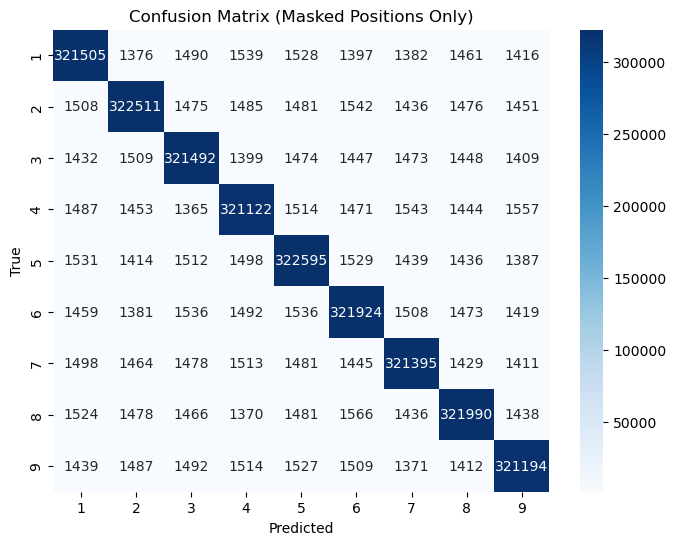


Classification Report:
              precision    recall  f1-score   support

           1      0.964     0.965     0.965    333094
           2      0.965     0.965     0.965    334365
           3      0.965     0.965     0.965    333083
           4      0.965     0.964     0.964    332956
           5      0.964     0.965     0.964    334341
           6      0.964     0.965     0.964    333728
           7      0.965     0.965     0.965    333114
           8      0.965     0.965     0.965    333749
           9      0.965     0.965     0.965    332945

    accuracy                          0.965   3001375
   macro avg      0.965     0.965     0.965   3001375
weighted avg      0.965     0.965     0.965   3001375


🔍 Sample #0
Input (with masked 0s):
[[6 2 4 0 0 0 7 9 8]
 [0 0 5 2 0 0 3 0 6]
 [9 0 0 0 8 6 4 5 2]
 [8 3 2 9 6 1 5 4 7]
 [5 7 0 3 2 4 0 6 1]
 [0 0 1 8 0 5 2 3 9]
 [1 4 7 6 3 2 9 8 5]
 [0 9 8 1 5 7 6 2 4]
 [2 0 6 4 0 8 1 7 0]]

True masked values:
[['_' '_' '_' '5' '1' '

In [24]:

# -----------------------------
# Evaluation (Masked Accuracy)
# -----------------------------
def masked_accuracy(y_true, y_pred, mask):
    y_pred_labels = np.argmax(y_pred, axis=-1)
    correct = (y_pred_labels == y_true) & mask
    return np.sum(correct) / np.sum(mask)

y_pred_val = model.predict(val_dataset)
acc = masked_accuracy(Y_val, y_pred_val, M_val)
print(f"\n✅ Masked Accuracy: {acc:.4f}")

# -----------------------------
# Evaluation & Visualization
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Final predictions
y_pred_labels = np.argmax(y_pred_val, axis=-1)

# Masked-only values
masked_preds = y_pred_labels[M_val]
masked_truths = Y_val[M_val]

# Confusion Matrix
cm = confusion_matrix(masked_truths, masked_preds, labels=np.arange(9))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 10), yticklabels=np.arange(1, 10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Masked Positions Only)')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(masked_truths, masked_preds, digits=3, target_names=[str(i) for i in range(1, 10)]))

# Visualize Some Predictions
def visualize_predictions(index):
    original = X_val[index].copy()
    true_vals = Y_val[index]
    preds = y_pred_labels[index]
    mask = M_val[index]

    print(f"\n🔍 Sample #{index}")
    print("Input (with masked 0s):")
    print(original.reshape(9, 9))

    print("\nTrue masked values:")
    masked_true = ['_' if not m else str(t+1) for t, m in zip(true_vals, mask)]
    print(np.array(masked_true).reshape(9, 9))

    print("\nPredicted masked values:")
    masked_pred = ['_' if not m else str(p+1) for p, m in zip(preds, mask)]
    print(np.array(masked_pred).reshape(9, 9))

# Visualize a few samples
for idx in [0, 155, 11]:
    visualize_predictions(idx)